<a href="https://colab.research.google.com/github/HayeonKimm/machine-Learning/blob/master/machine_trace/ETA_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 1. Make the best model for TADA ETA data
Chapter 2에서 배운 tree algorithm들과 Chapter 3에서 배운 unsupervised learning을 통한 전처리를 응용해서 가장 좋은 성능을 내는 TADA ETA 예측모델을 만들어봅시다.

1. 트레이닝셋과 테스트셋의 split은 아래와 같이 고정하도록 하겠습니다. 실습 코드에서는 아래의 random_state=0이 없었어서 데이터셋 생성 시 마다 순서가 달라졌는데, 이번엔 모두가 같은 data split을 가지고 동등하게 평가를 진행하도록 하겠습니다. 
```
tada_eta = tada_eta.sample(frac=1, random_state=0).reset_index(drop=True)
train = tada_eta[:12000]
test = tada_eta[12000:]
```
2. 데이터셋에 normalization이나 PCA와 같은 전처리를 하고 그 후에 아래의 **Tips**에 있는 것과 같이 grid search와 category feature를 활용할 수 있는 방법을 적용해보세요. decision tree의 특성상, 그리고 저희의 input feature가 많지 않기 때문에, 전처리가 성능에 별로 도움이 안 될 수도 있으니 당황하지 않으셔도 됩니다!
3. 이미 구현된 코드 사용은 sklearn 패키지 안에 있는 tree, ensemble 모델들과 unsupervised learning 알고리즘들로 제한하겠습니다. 다만 직접 구현하신다면 모델 종류에 제한을 두지 않겠습니다. 
4. input feature의 종류는 실습 코드에서는 4개(*api_eta,	month, hour, distance*)만 사용했으나, 이번 과제에서는 원 데이터셋에서 자유롭게 변형하여 사용하셔도 됩니다.
5. **[채점 기준]** test set에 대한 MSE(소숫점 둘째 자리까지)를 기준으로 점수를 매기도록 하겠습니다. test set은 절대 학습에 이용하시면 안됩니다!! 원래 generalization이 되는지 평가 하기 위해서는 test set이 주어지지 않는 것이 맞는데, 이 과제에서 주어지는 test set은 model selection을 위한 **validation set**이라고 생각하시고 과제를 진행해주세요. 그리고 randomness가 들어간 모델의 경우 평가를 위해서 random_state를 고정해주세요.
 *   목표 MSE 8 이하 달성: 10점   
 *   MSE 8.05 이하 달성: 9점
 *   MSE 8.15 이하 달성: 8점
 *   Chapter 3까지의 내용도 활용하여 MSE 8.25 이하 달성: 7점
 *   Chapter 2까지의 내용만 활용하여 MSE 8.25 이하 달성: 6점
 *   제출하였으나 코드 실행 안됨: 5점

6. **[Tips]** 
  1. 모델의 hyperparamter(*max_depth, min_samples_leaf* 등)를 찾을 때 아래 예시와 같이 sklearn의 GridSearchCV를 이용하면 주어진 모든 조합의 hyperparameter들에 대해서 train, validation을 진행해서 최적의 hyperparameter를 찾을 수 있습니다. 
     * 아래 코드에서와 같이 cv=3이라고 하면 3-fold cross validation을 \할 수 있습니다.
```
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# Hyperparameter 조합 정의
param_grid = {'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4, 5],
           'min_samples_leaf': [1, 20, 100],
          'learning_rate': [0.01, 0.02, 0.05],
          'loss': ['ls']} 
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                           param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
reg = ensemble.GradientBoostingRegressor(**grid_search.best_params_)
```
      * 우리는 validation set이 정해져있으므로 아래와 같이 PredefinedSplit을 통해 바로 validation set을 정해주고 이를 cv에 넘겨주면, validation set에 대해서 가장 성능이 좋은 hyperparameter를 찾을 수 있습니다. 이 방법을 추천드립니다.
      ```
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit    
# train set과 test set의 input과 output를 각각 이어 붙여서 X,y를 정의 
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
# 전체 데이터 X에서 training data에 해당하는 index는 -1, test data에 해당하는 index는 0이 되도록, 
# 여기서는 [-1, -1, ... , -1, 0, 0, ... , 0] 같은 형태의 1차원 배열 test fold와 predefined split을 정의
pds = PredefinedSplit(test_fold=[-1]*len(x_train)+[0]*len(x_test))
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                           param_grid=param_grid, 
                           cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)
      ```
  2.   **sklearn.ensemble.HistGradientBoostingRegressor**은 gradient boosting 모델의 또 다른 구현인데, 이 모델은 input feature로 category feature도 사용가능합니다. 그러기 위해서는 우선 아래 예시와 같이 category feature를 ordinal encoding을 통해서 0부터 (category갯수-1)까지의 숫자 중 하나로 변환해줘야 합니다. ordinal encoding을 한 후, HistGradientBoostingRegressor을 정의할 때 input parameter인 categorical_feature를 통해 몇 번째 feature가 categorical feature인지 알려줘야 합니다. 예를 들어 세 번째(index는 2) feature가 categorical feature라면 categorical_features=[2]가 됩니다. categorical feature를 쓰지 않더라도 이 HistGradientBoostingRegressor를 쓰면 데이터의 갯수가 많을때 연산 속도가 훨씬 빠르니 GradientBoostingRegressor 대신 사용을 추천드립니다.
```
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
# Ordianl Encoding
enc = sklearn.preprocessing.OrdinalEncoder(dtype=np.int32)
ordinal = enc.fit_transform(np.asarray(tada_eta['pickup_gu']).reshape(-1,1))
tada_eta['pickup_gu'] = ordinal[:,0]
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat'],1)
```
    * **[주의점]** category feature에 대해서는 normalization과 PCA 등의 차원축소를 하시면 안됩니다. 이 같은 전처리를 하시려면 category feature는 제외하고 전처리를 진행하시고, 그 후에 category feature를 다시 붙여주세요. 
    * HistGradientBoostingRegressor에서는 tree의 갯수를 정해주기 위해서 'n_estimators' 대신 'max_iter'라는 이름의 parameter를 사용합니다.

7.  **[Optional]** 구, 시간대, 월과 같은 feature를 예측에 더욱 더 효과적으로 활용하기 위해서 [data.seoul.go.kr](https://data.seoul.go.kr/dataList/datasetList.do)에 있는 서울시 공공데이터셋을 활용해도 됩니다. 아래 Reference에 사용가능한 데이터의 예시들이 있습니다. 다만 예측에 별로 도움이 되지 않는 데이터도 있을 수 있으니 잘 살펴보시고 사용해주세요.


---

[Reference]
*   https://scikit-learn.org/stable/modules/tree.html
*   https://scikit-learn.org/stable/modules/ensemble.html
*   https://scikit-learn.org/stable/unsupervised_learning.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
*  [서울시 차량통행속도 (구별/월별) 통계](https://data.seoul.go.kr/dataList/10846/S/2/datasetView.do)
*  [서울시 승용차통행속도 (시간대별) 통계](https://data.seoul.go.kr/dataList/265/S/2/datasetView.do)
*  [서울시 자동차등록 (월별/구별) 통계](https://data.seoul.go.kr/dataList/255/S/2/datasetView.do)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# scikit-learn 최신 버전으로 업그레이드
# !pip install -U scikit-learn
import sklearn
print("scikit-learn version: ", sklearn.__version__)

scikit-learn version:  0.22.2.post1


### Regression Tree with Tada ETA data



*   ATA: Actual Time of Arrival
*   ETA: Expected Time of Arrival
*   api_eta: 앱 API에서 예측된 ETA



In [ ]:
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
print(tada_eta.columns)
tada_eta.head()

Index(['ATA', 'id', 'api_eta', 'created_at_kst', 'month', 'pickup_lng',
       'pickup_lat', 'pickup_gu', 'driver_id', 'driver_lng', 'driver_lat',
       'hour'],
      dtype='object')


,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01T00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01T00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15T00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31T00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05T00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0


In [ ]:
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat','pickup_gu'],1)
tada_eta.head()

# sklearn의 tree는 범주 데이터는 다루지 못함. 이 경우에 one-hot encoding은 비효율적. 구 데이터도 활용하고 싶다면 h2o 참고

,ATA,api_eta,month,hour,distance
0,10.60,5.65,12,0,52.400202
1,9.20,8.60,12,0,44.465889
2,10.85,10.53,12,0,149.731535
3,5.52,1.92,7,0,1.000535
4,8.60,7.10,7,0,35.014797


## 샘플링

In [ ]:
tada_eta = tada_eta.sample(frac=1, random_state=0).reset_index(drop=True)
tada_eta.head()

,ATA,api_eta,month,hour,distance
0,6.13,8.32,12,22,44.521977
1,5.37,3.05,12,11,3.989066
2,6.27,5.00,7,19,4.814699
3,10.52,8.47,12,21,77.341173
4,12.45,6.65,7,12,14.888851


In [ ]:
tada_eta.shape

(13916, 5)

In [ ]:
train = tada_eta[:12000]
test = tada_eta[12000:]

In [ ]:
x_train = np.asarray(train.drop('ATA',1))
y_train = np.asarray(train['ATA'])
x_test = np.asarray(test.drop('ATA',1))
y_test = np.asarray(test['ATA'])
eta_features = [x for i,x in enumerate(tada_eta.columns) if i!=0]

# PCA

In [ ]:
# Principal Components Analysis (PCA)
# Using PCA to find the first two principal components of the breast cancer dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

# Before applying PCA, each feature should be centered (zero mean) and with unit variance
# PCA를 하기전에는 정규화를 해야한다. 그렇지 않으면 성능이 좋지 않을 수 있다..!

X_normalized = StandardScaler().fit(train).transform(train)  
pca = PCA(n_components = 2).fit(X_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
X_pca = pca.transform(X_normalized) # transform은 해줘야 한다.

print(train.shape, X_pca.shape)

(12000, 5) (12000, 2)


In [ ]:
type(X_pca)

numpy.ndarray

In [ ]:
eta_features

['api_eta', 'month', 'hour', 'distance']

In [ ]:
params = {'n_estimators': 100, # 트리의 개수
          'max_depth': 3,
           'min_samples_leaf': 5,
          'learning_rate': 0.05,
          'loss': 'ls'} # 'squared_error'와 같음

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error # 절대값
from sklearn import ensemble

# 1 way

## 수작업 버전

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 6.8226
The initial error of API ETA on test set: 8.8452
The mean absolute error (MAE) on test set: 2.0223
The initial error of API ETA on test set: 2.0851


# 2 way

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# Hyperparameter 조합 정의
param_grid = {'n_estimators': [100, 200, 300],
  'max_depth': [2, 3, 4, 5],
   'min_samples_leaf': [1, 20, 100],
  'learning_rate': [0.01, 0.02, 0.05],
  'loss': ['ls']} 
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                   param_grid=param_grid, 
                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
reg = ensemble.GradientBoostingRegressor(**grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  6.1min finished


{'learning_rate': 0.02, 'loss': 'ls', 'max_depth': 2, 'min_samples_leaf': 20, 'n_estimators': 300}


# way 3 그리드서치CV 적용..
## 왜 way 1보다 더 높지요

In [ ]:
params = {'n_estimators': 300, # 트리의 개수
          'max_depth': 2,
           'min_samples_leaf': 20,
          'learning_rate': 0.02,
          'loss': 'ls'} # 'squared_error'와 같음


reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 6.9134
The initial error of API ETA on test set: 8.8452
The mean absolute error (MAE) on test set: 2.0447
The initial error of API ETA on test set: 2.0851


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit    


# train set과 test set의 input과 output를 각각 이어 붙여서 X,y를 정의 
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

# 전체 데이터 X에서 training data에 해당하는 index는 -1, test data에 해당하는 index는 0이 되도록, 
# 여기서는 [-1, -1, ... , -1, 0, 0, ... , 0] 같은 형태의 1차원 배열 test fold와 predefined split을 정의
pds = PredefinedSplit(test_fold=[-1]*len(x_train)+[0]*len(x_test))
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                   param_grid=param_grid, 
                   cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)

Fitting 1 folds for each of 108 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.0min finished


{'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}


In [ ]:
params = {'n_estimators': 200, # 트리의 개수
          'max_depth': 3,
           'min_samples_leaf': 1,
          'learning_rate': 0.05,
          'loss': 'ls'} # 'squared_error'와 같음


reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 6.6923
The initial error of API ETA on test set: 8.8452
The mean absolute error (MAE) on test set: 1.9949
The initial error of API ETA on test set: 2.0851


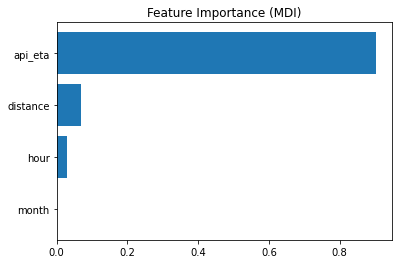

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(eta_features)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

HistGradientBoostingRegressor를 쓰면 데이터의 갯수가 많을때 연산 속도가 훨씬 빠르다.

이 모델은 input feature로 category feature도 사용가능합니다. 그러기 위해서는 우선 아래 예시와 같이 category feature를 ordinal encoding을 통해서 0부터 (category갯수-1)까지의 숫자 중 하나로 변환해줘야 합니다. 

ordinal encoding을 한 후, HistGradientBoostingRegressor을 정의할 때 input parameter인 categorical_feature를 통해 몇 번째 feature가 categorical feature인지 알려줘야 합니다. 예를 들어 세 번째(index는 2) feature가 categorical feature라면 categorical_features=[2]가 됩니다.


categorical feature를 쓰지 않더라도 이 HistGradientBoostingRegressor를 쓰면 데이터의 갯수가 많을때 연산 속도가 훨씬 빠르니 GradientBoostingRegressor 대신 사용을 추천드립니다.

# way 4 HistGradientBoostingRegressor

In [ ]:
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
# Ordianl Encoding
enc = sklearn.preprocessing.OrdinalEncoder(dtype=np.int32)
ordinal = enc.fit_transform(np.asarray(tada_eta['pickup_gu']).reshape(-1,1))
tada_eta['pickup_gu'] = ordinal[:,0] # 0번째 인덱스 칼럼
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat'],1)

In [ ]:
tada_eta.head()

,ATA,api_eta,month,pickup_gu,hour,distance
0,10.60,5.65,12,8,0,52.400202
1,9.20,8.60,12,2,0,44.465889
2,10.85,10.53,12,7,0,149.731535
3,5.52,1.92,7,23,0,1.000535
4,8.60,7.10,7,23,0,35.014797


In [ ]:
pickup_gu_m=tada_eta['pickup_gu']
tada_eta=tada_eta.drop('pickup_gu',1)

In [ ]:
tada_eta.head(1)

,ATA,api_eta,month,hour,distance
0,10.6,5.65,12,0,52.400202


In [ ]:
# Principal Components Analysis (PCA)
# Using PCA to find the first two principal components of the breast cancer dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

# Before applying PCA, each feature should be centered (zero mean) and with unit variance
# PCA를 하기전에는 정규화를 해야한다. 그렇지 않으면 성능이 좋지 않을 수 있다..!

X_normalized = StandardScaler().fit(train).transform(train)  
pca = PCA(n_components = 2).fit(X_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
X_pca = pca.transform(X_normalized) # transform은 해줘야 한다.

print(train.shape, X_pca.shape)

(12000, 5) (12000, 2)


In [ ]:
tada_eta['pickup_gu']=pickup_gu_m
tada_eta

,ATA,api_eta,month,hour,distance,pickup_gu
0,10.60,5.65,12,0,52.400202,8
1,9.20,8.60,12,0,44.465889,2
2,10.85,10.53,12,0,149.731535,7
3,5.52,1.92,7,0,1.000535,23
4,8.60,7.10,7,0,35.014797,23
...,...,...,...,...,...,...
13911,8.22,5.55,12,23,7.508001,19
13912,1.37,0.98,7,23,1.560660,19
13913,4.22,4.15,7,23,1.647304,19
13914,4.85,5.38,7,23,73.629324,19


In [ ]:
tada_eta.columns

Index(['ATA', 'api_eta', 'month', 'hour', 'distance', 'pickup_gu'], dtype='object')

## grid search

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# Hyperparameter 조합 정의
param_grid = {'max_iter': [100, 200, 300],
  'max_depth': [2, 3, 4, 5],
   'min_samples_leaf': [1, 20, 100],
  'learning_rate': [0.01, 0.02, 0.05]}
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.HistGradientBoostingRegressor(), 
                   param_grid=param_grid, 
                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
reg = ensemble.HistGradientBoostingRegressor(**grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.4min finished


{'learning_rate': 0.02, 'max_depth': 2, 'max_iter': 300, 'min_samples_leaf': 1}


In [ ]:
params = {'max_iter': 300, # 트리의 개수
          'max_depth': 2,
           'min_samples_leaf': 1,
          'learning_rate': 0.02,
          } # 'squared_error'와 같음


hist = ensemble.HistGradientBoostingRegressor(**params)
hist.fit(x_train, y_train)

mse = mean_squared_error(y_test, hist.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, hist.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 6.9250
The initial error of API ETA on test set: 8.8452
The mean absolute error (MAE) on test set: 2.0461
The initial error of API ETA on test set: 2.0851


In [ ]:
>>> from sklearn.experimental import enable_hist_gradient_boosting  # noqa
>>> # 이제 앙상블에서 정상적으로 가져올 수 있습니다.
>>> from sklearn.ensemble import HistGradientBoostingRegressor

## PredefinedSplit

In [ ]:
# 파라미터 값 좀 더 확장
param_grid = {'max_iter': [100, 200, 300,400,500],
  'max_depth': [1,2, 3, 4, 5],
   'min_samples_leaf': [1, 20, 50, 100],
  'learning_rate': [0.01, 0.02, 0.05]}
  # 'loss': ['ls']} 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
# from sklearn.ensemble import HistGradientBoostingRegressor


# train set과 test set의 input과 output를 각각 이어 붙여서 X,y를 정의 
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

# 전체 데이터 X에서 training data에 해당하는 index는 -1, test data에 해당하는 index는 0이 되도록, 
# 여기서는 [-1, -1, ... , -1, 0, 0, ... , 0] 같은 형태의 1차원 배열 test fold와 predefined split을 정의
pds = PredefinedSplit(test_fold=[-1]*len(x_train)+[0]*len(x_test))
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.HistGradientBoostingRegressor(), 
                   param_grid=param_grid,
                   cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)

Fitting 1 folds for each of 300 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


{'learning_rate': 0.02, 'max_depth': 3, 'max_iter': 400, 'min_samples_leaf': 1}


In [ ]:
params = {'max_iter': 400, # 트리의 개수
          'max_depth': 3,
           'min_samples_leaf': 1,
          'learning_rate': 0.02,
         } # 'squared_error'와 같음


hist = ensemble.HistGradientBoostingRegressor(**params)
hist.fit(x_train, y_train)

mse = mean_squared_error(y_test, hist.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, hist.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 6.6860
The initial error of API ETA on test set: 8.8452
The mean absolute error (MAE) on test set: 1.9927
The initial error of API ETA on test set: 2.0851


결론 : 카테고리 피쳐 제외 PCA + HistGradientBoostingRegressor + PredefinedSplit + GridSearchCV 성능이 제일 좋다

### The mean squared error (MSE) on test set: 6.6860

[채점 기준] test set에 대한 MSE(소숫점 둘째 자리까지)를 기준으로 점수를         매기도록 하겠습니다.   
   
test set은 절대 학습에 이용하시면 안됩니다!! 원래 generalization이 되는지 평가 하기 위해서는 test set이 주어지지 않는 것이 맞는데, 이 과제에서 주어지는 test set은 model selection을 위한 validation set이라고 생각하시고 과제를 진행해주세요. 그리고 randomness가 들어간 모델의 경우 평가를 위해서 random_state를 고정해주세요.

목표 MSE 8 이하 달성: 10점   
MSE 8.05 이하 달성: 9점   
MSE 8.15 이하 달성: 8점   
Chapter 3까지의 내용도 활용하여 MSE 8.25 이하 달성: 7점   
Chapter 2까지의 내용만 활용하여 MSE 8.25 이하 달성: 6점   
제출하였으나 코드 실행 안됨: 5점   

----------------------------